## Registration Project

In [25]:
# Library imports
import matplotlib.pyplot as plt
import imageio.v3 as iio
import SimpleITK as sitk
import numpy as np
import elastix
import os

# General file paths
BASE_PATH = "../DevelopmentData/DevelopmentData"

path = r'C:/Users/20212238/OneDrive - TU Eindhoven/Documents/TUE/M - Jaar 1/Capita Selecta in MI/'
ELASTIX_PATH = os.path.join(path,'elastix-5.0.0-win64/elastix.exe')
TRANSFORMIX_PATH = os.path.join(path,'elastix-5.0.0-win64/transformix.exe')

if not os.path.exists(ELASTIX_PATH):
    raise IOError('Elastix cannot be found, please set the correct ELASTIX_PATH.')
if not os.path.exists(TRANSFORMIX_PATH):
    raise IOError('Transformix cannot be found, please set the correct TRANSFORMIX_PATH.')

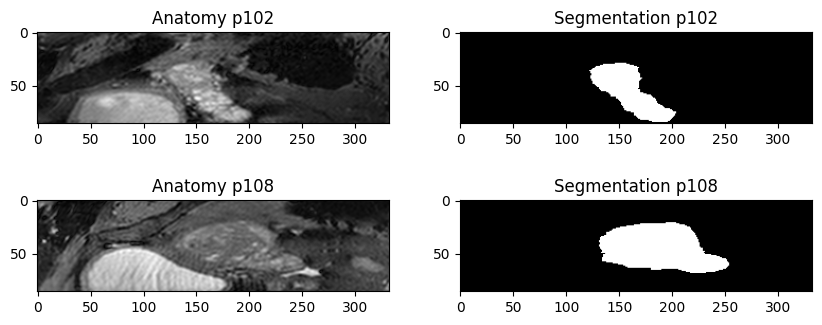

In [23]:
# Load data
folder1 = "p102"
folder2 = "p108"
anatomy_path1 = os.path.join(BASE_PATH, folder1, "mr_bffe.mhd")
# itk_fixed_image = sitk.ReadImage(anatomy_path)
anatomy_image1 = sitk.GetArrayFromImage(sitk.ReadImage(anatomy_path1))
anatomy_path2 = os.path.join(BASE_PATH, folder2, "mr_bffe.mhd")
anatomy_image2 = sitk.GetArrayFromImage(sitk.ReadImage(anatomy_path2))

segmentation_path1 = os.path.join(BASE_PATH, folder1, "prostaat.mhd")
# itk_moving_image = sitk.ReadImage(moving_image_path)
segmentation_image1 = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_path1))
segmentation_path2 = os.path.join(BASE_PATH, folder2, "prostaat.mhd")
segmentation_image2 = sitk.GetArrayFromImage(sitk.ReadImage(segmentation_path2))


# Plot MR data
slice_nr = 100
fig, ax = plt.subplots(2, 2, figsize=(10, 4))
ax[0,0].imshow(anatomy_image1[:,:,slice_nr], cmap="gray")
ax[0,0].set_title(f"Anatomy {folder1}")
ax[0,1].imshow(segmentation_image1[:,:,slice_nr], cmap="gray")
ax[0,1].set_title(f"Segmentation {folder1}");
ax[1,0].imshow(anatomy_image2[:,:,slice_nr], cmap="gray")
ax[1,0].set_title(f"Anatomy {folder2}")
ax[1,1].imshow(segmentation_image2[:,:,slice_nr], cmap="gray")
ax[1,1].set_title(f"Segmentation {folder2}");

C:/Users/20212238/OneDrive - TU Eindhoven/Documents/TUE/M - Jaar 1/Capita Selecta in MI/elastix-5.0.0-win64/elastix.exe -f ../DevelopmentData/DevelopmentData\p102\mr_bffe.mhd -m ../DevelopmentData/DevelopmentData\p108\mr_bffe.mhd -p ../DevelopmentData/DevelopmentData\parameters_bspline_multires.txt -out ../DevelopmentData/DevelopmentData\results


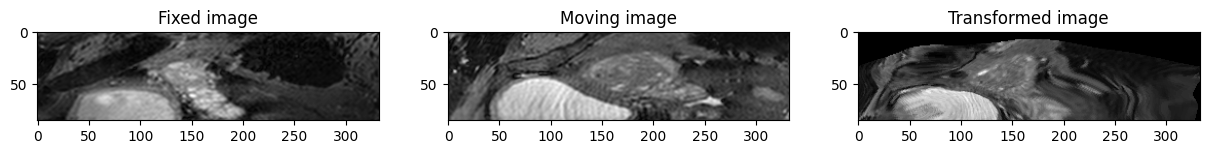

In [18]:
el = elastix.ElastixInterface(elastix_path=ELASTIX_PATH)

# Make a results directory if non exists
if os.path.exists(os.path.join(BASE_PATH, 'results')) is False:
    os.mkdir(os.path.join(BASE_PATH, 'results'))

# Define the paths to the two images you want to register
fixed_image_path = anatomy_path1
fixed_image = anatomy_image1
moving_image_path = anatomy_path2
moving_image = anatomy_image2
fixed_segm_path = segmentation_path1
fixed_segm = segmentation_image1
moving_segm_path = segmentation_path2
moving_segm = segmentation_image2

# Execute the registration. Make sure the paths below are correct
el.register(
    fixed_image=fixed_image_path,
    moving_image=moving_image_path,
    parameters=[os.path.join(BASE_PATH, "parameters_bspline_multires.txt")],
    output_dir=os.path.join(BASE_PATH, 'results')
)

# Find result
result_path = os.path.join(BASE_PATH, 'results', 'result.0.mhd')
itk_transformed_image = sitk.ReadImage(result_path)
transformed_image = sitk.GetArrayFromImage(itk_transformed_image)

# Plot the result
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(fixed_image[:,:,slice_nr], cmap='gray')
ax[0].set_title('Fixed image')
ax[1].imshow(moving_image[:,:,slice_nr], cmap='gray')
ax[1].set_title('Moving image')
ax[2].imshow(transformed_image[:,:,slice_nr], cmap='gray')
ax[2].set_title('Transformed image');

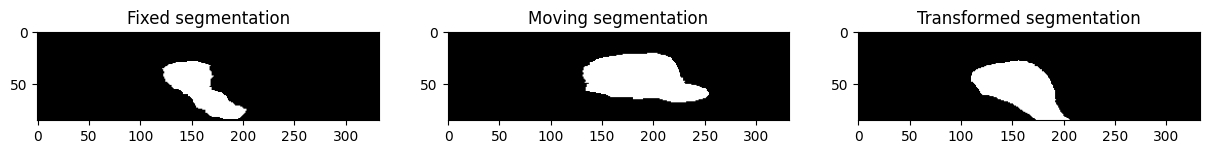

In [20]:
# Make a new transformix object tr with the CORRECT PATH to transformix
transform_path = os.path.join(BASE_PATH, 'results', 'TransformParameters.0.txt')
tr = elastix.TransformixInterface(parameters=transform_path, transformix_path=TRANSFORMIX_PATH)

# Transform a new image with the transformation parameters
transformed_segm_path = tr.transform_image(moving_segm_path, output_dir=os.path.join(BASE_PATH, 'results'))
transformed_segm = sitk.GetArrayFromImage(sitk.ReadImage(transformed_segm_path))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(fixed_segm[:,:,slice_nr], cmap='gray')
ax[0].set_title('Fixed segmentation')
ax[1].imshow(moving_segm[:,:,slice_nr], cmap='gray')
ax[1].set_title('Moving segmentation')
ax[2].imshow(transformed_segm[:,:,slice_nr], cmap='gray')
ax[2].set_title('Transformed segmentation');

In [26]:
def dice_coefficient(mask1, mask2):
    if mask1.shape != mask2.shape:
        raise ValueError("Input masks must have the same shape.")
    
    intersection = np.sum(mask1*mask2)
    volume_sum = np.sum(mask1) + np.sum(mask2)

    if volume_sum == 0:
        return 1.0  # If both masks are empty, they are considered identical
    
    return 2.0 * intersection / volume_sum

# print("Dice coefficient after rigid registration:", dice_coefficient(fixed_image_mask, moving_image_mask))
print("Dice coefficient after nonlinear registration:", dice_coefficient(fixed_segm, transformed_segm))

Dice coefficient after nonlinear registration: 0.6728962665280787


In [ ]:
# Get the Jacobian determinant
jacobian_determinant_path = tr.jacobian_determinant(output_dir=os.path.join(BASE_PATH, 'results'))
itk_jacobian_determinant = sitk.ReadImage(jacobian_determinant_path)
jacobian_determinant = sitk.GetArrayFromImage(itk_jacobian_determinant)

# Plot Jacobian determinant
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].imshow(transformed_image[:,:,slice_nr], cmap='gray')
ax[0].set_title('Transformed image')

im1 = ax[1].imshow(jacobian_determinant[:,:,slice_nr])
ax[1].set_title('Jacobian determinant')
fig.colorbar(im1, ax=ax[1])

im2 = ax[2].imshow(jacobian_determinant[:,:,slice_nr] > 0, cmap='gray')
ax[2].set_title('Binarized Jacobian determinant')
fig.colorbar(im2, ax=ax[2]);

C:/Users/20212238/OneDrive - TU Eindhoven/Documents/TUE/M - Jaar 1/Capita Selecta in MI/elastix-5.0.0-win64/elastix.exe -f ../DevelopmentData/DevelopmentData\p102\prostaat.mhd -m ../DevelopmentData/DevelopmentData\p108\prostaat.mhd -p ../DevelopmentData/DevelopmentData\parameterswithpenalty.txt -out ../DevelopmentData/DevelopmentData\results_penalty


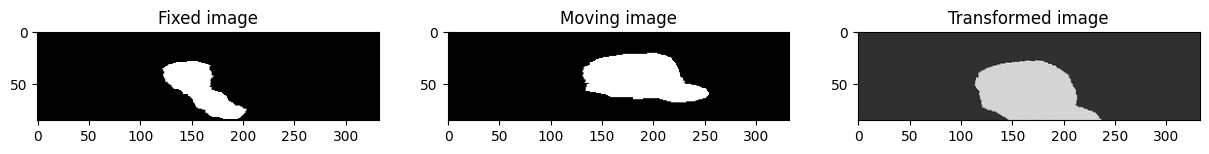

In [56]:
# Make a results directory if non exists
if os.path.exists(os.path.join(BASE_PATH, 'results_penalty')) is False:
    os.mkdir(os.path.join(BASE_PATH, 'results_penalty'))

# Define the paths to the two images you want to register
# fixed_image_path = anatomy_path1
# fixed_image = anatomy_image1
# moving_image_path = anatomy_path2
# moving_image = anatomy_image2
fixed_image_path = segmentation_path1
fixed_image = segmentation_image1
moving_image_path = segmentation_path2
moving_image = segmentation_image2

# Execute the registration. Make sure the paths below are correct
el.register(
    fixed_image=fixed_image_path,
    moving_image=moving_image_path,
    parameters=[os.path.join(BASE_PATH, "parameterswithpenalty.txt")],
    output_dir=os.path.join(BASE_PATH, 'results_penalty')
)

# Find result
result_path = os.path.join(BASE_PATH, 'results_penalty', 'result.0.mhd')
itk_transformed_image = sitk.ReadImage(result_path)
transformed_image = sitk.GetArrayFromImage(itk_transformed_image)

# Plot the result
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(fixed_image[:,:,slice_nr], cmap='gray')
ax[0].set_title('Fixed image')
ax[1].imshow(moving_image[:,:,slice_nr], cmap='gray')
ax[1].set_title('Moving image')
ax[2].imshow(transformed_image[:,:,slice_nr], cmap='gray')
ax[2].set_title('Transformed image');